<a href="https://colab.research.google.com/github/sfansaria/GaussianMIxtureModel_ImageSegmentation/blob/main/GMM_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install scipy  --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Input the image name: girl
Input number of classes: 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1: Log Likelihood = -12248196.872279318
Iteration 2: Log Likelihood = -9510575.871935036
Iteration 3: Log Likelihood = -7052828.484371448
Iteration 4: Log Likelihood = -4616872.619986116
Iteration 5: Log Likelihood = -2391422.5584780695
Iteration 6: Log Likelihood = -1252847.6813210081
Iteration 7: Log Likelihood = -782711.781287984
Iteration 8: Log Likelihood = -637203.8515595221
Iteration 9: Log Likelihood = -585626.7534511092
Iteration 10: Log Likelihood = -564347.4204683158
Iteration 11: Log Likelihood = -554863.3837657515
Iteration 12: Log Likelihood = -550442.2721135472
Iteration 13: Log Likelihood = -548302.3950781086
Iteration 14: Log Likelihood = -547229.5530126503
Iteration 15: Log Likelihood = -546674.1469224729
Iteration 16: Log Likelihood = -546378.5519343417
Iteration 17: Log Likelihood = -546217.6260583039
Iteration 18: Log Likelihood = -546128.4419979271
Iteration 19: Log Likelihood = -546078.343304221
Iteration 20: Log Likelihood = -546049.9168450888
Iteratio

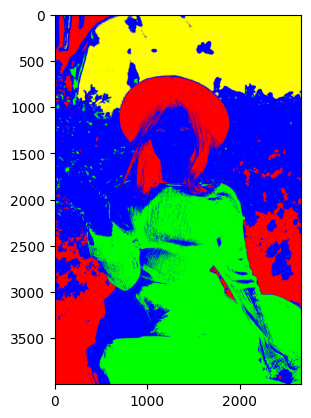

In [ ]:
import numpy as np

from PIL import Image
COLORS = [(255, 0, 0),(0, 255, 0),(0, 0, 255),(255, 255, 0),(255, 0, 255)]

def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


class GMM:
  def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
    self.ncomp = ncomp
    self.mus = np.asarray(initial_mus)
    self.covs = np.asarray(initial_covs)
    self.priors = np.asarray(initial_priors)

  def inference(self, datas):  #E-step
      unnormalized_probs = []
      for i in range(self.ncomp):
          mu, cov, prior = self.mus[i, :],self.covs[i, :, :], self.priors[i]
          unnormalized_prob  = prior*multivariate_normal.pdf(datas, mean=mu, cov=cov)
          unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
      preds = np.concatenate(unnormalized_probs, axis = 1)
      log_likelihood = np.sum(preds, axis=1)
      log_likelihood = np.sum(np.log(log_likelihood))

      preds = preds / np.sum(preds, axis=1, keepdims=True)
      return np.asarray(preds), log_likelihood

  def update(self, datas, beliefs): #M step
      new_mus, new_covs, new_priors = [], [], []
      soft_counts = np.sum(beliefs, axis=0)
      for i in range(self.ncomp):
        new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
        new_mu /= soft_counts[i]
        new_mus.append(new_mu)

        data_shifted = np.subtract(datas, np.expand_dims(new_mu, 0))
        new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1),data_shifted)), data_shifted)
        new_cov /= soft_counts[i]
        new_covs.append(new_cov)
        new_priors.append(soft_counts[i] / np.sum(soft_counts))
      self.mus = np.asarray(new_mus)
      self.covs = np.asarray(new_covs)
      self.priors = np.asarray(new_priors)


if __name__=='__main__':
  #load image
  image_name = input('Input the image name: ')
  image_path = '/content/drive/MyDrive/ml_datasets/{}.jpg'.format(image_name)
  image = load_image(image_path)
  image_height, image_width, image_channels = image.shape
  image_pixels = np.reshape(image, (-1, image_channels))
  _mean = np.mean(image_pixels,axis=0,keepdims=True)
  _std = np.std(image_pixels,axis=0,keepdims=True)
  image_pixels = (image_pixels - _mean) / _std   #Normalization

  #Input number of classes
  ncomp = int(input('Input number of classes: '))

  #Apply K-Means to find the initial weights and covariance matrices for GMM

  kmeans = KMeans(n_clusters=ncomp)
  labels = kmeans.fit_predict(image_pixels)
  initial_mus = kmeans.cluster_centers_
  initial_priors, initial_covs = [], []
  for i in range(ncomp):
    datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j]==i]).T
    initial_covs.append(np.cov(datas))
    initial_priors.append(datas.shape[1] / float(len(labels)))

  #initialize a GMM
  gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)


  #EM ALGORITHM
  prev_log_likelihood = None
  for i in range(1000):
    beliefs, log_likelihood = gmm.inference(image_pixels)  #E-STEP
    gmm.update(image_pixels, beliefs)   #M-STEP
    print('Iteration {}: Log Likelihood = {}'.format(i+1, log_likelihood))
    if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood


  #Show result
  beliefs, log_likelihood = gmm.inference(image_pixels)
  map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
  segmented_map = np.zeros((image_height, image_width, 3))
  for i in range(image_height):
      for j in range(image_width):
          hard_belief = np.argmax(map_beliefs[i, j, :])
          segmented_map[i,j,:] = np.asarray(COLORS[hard_belief])/255.0

  plt.imshow(segmented_map)
  plt.show()




